In [2]:
import numpy as np
import msprime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import resample
from statistics import mean, stdev
from sklearn.model_selection import KFold
from math import sqrt
import seaborn as sns
import allel

In [3]:
seq_len = 1e8
rec_rate = 1e-8
mut_rate = 1e-8
split_time = 50 # in generations

In [4]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=1000) 
demography.add_population(name="B", initial_size=1000)
demography.add_population(name="C", initial_size=1000)
demography.add_population_split(time=split_time, derived=["A", "B"], ancestral="C")

PopulationSplit(time=50, derived=['A', 'B'], ancestral='C')

In [5]:
 ts = msprime.sim_ancestry(
        samples={'A':1000, 'B':1000}, # diploid samples
        demography=demography,
        ploidy=2,
        sequence_length=seq_len,
        discrete_genome=False,
        recombination_rate=rec_rate, 
        model='dtwf',
    )

ts = msprime.sim_mutations(
    ts, 
    rate=mut_rate, 
    discrete_genome=False,
    start_time=split_time,
    )

In [6]:
ts

In [22]:
for site in ts.sites():
    print(site)
    break

Site(id=0, position=8473.858337816917, ancestral_state='A', mutations=[Mutation(id=0, site=0, node=23066, derived_state='T', parent=-1, metadata=b'', time=831.8728790942114)], metadata=b'')


22564

## Functions

In [6]:
def get_fst(dA, dB, dAB):
    mean_within = (dA + dB) / 2
    between = dAB 
    Fst = 1 - mean_within.sum() / between.sum()
    return Fst

In [7]:
def get_fst_general(ts, pop1_samples, pop2_samples, sites_index):
    """return fst
    ts = tree seqeunce
    pop1_samples = the samples from the first popualtion to be used
    pop2_samples = the samples from the second population to be used
    sites_index = the indexs of the sites to be used.
   
    all of  (pop1_samples, pop2_samples, and sites_index) may have duplicates.
    """
   
    ga = allel.GenotypeArray(
        ts.genotype_matrix().reshape(
            ts.num_sites, ts.num_samples, 1),
        dtype='i1')
    
    ac1 = ga[sites_index][:, pop1_samples, :].count_alleles()
    ac2 = ga[sites_index][:, pop2_samples].count_alleles()
    num, denom = allel.hudson_fst(ac1, ac2)
    fst = np.sum(num) / np.sum(denom)
    return fst

In [8]:
def get_CI_normal(data):
    est_mean = mean(data)
    
    length = len(data)

    upper = est_fst + 1.96 * (stdev(data) / sqrt(length))
    lower = est_fst - 1.96 * (stdev(data) / sqrt(length))

    return lower, upper


def get_CI_quantile(data):

    lower = np.quantile(data, 0.05)
    upper = np.quantile(data, 0.95)

    return lower, upper

#### Bootstrap Resampling

In [9]:
def bootstrap(ts, popA, popB, bootstrap_time, bootstrap_size, size, fst, sites_index, method):
    '''
    Bootstrap Resampling over the given sample and return the coverage rate
    @method = 0 over individuals otherwise over sites
    ''' 
    
    popA_resample = popA
    popB_resample = popB
    sites_resample = sites_index
    
    within = []
    for i in range(bootstrap_time):
        fst_bt = []
        for j in range(bootstrap_size):
            
            if method == 0:
                popA_resample = np.random.choice(popA, size, replace=True)
                popB_resample = np.random.choice(popB, size, replace=True)
            else:
                sites_resample = np.random.choice(sites_index, size, replace=True)
                
            fst_bt.append(get_fst_general(ts, popA_resample, popB_resample, sites_resample))
            
        lower, upper = get_CI_quantile(fst_bt)
        
        print((lower, upper))

        if fst < upper and fst > lower:
            within.append(1)
        else:
            within.append(0)
            
            
    print('Coverage rate is: ', mean(within))

    return mean(within)

#### Jackknife Resampling 
see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold 
for reference of kfold split

In [92]:
def jackknife_ind(kf, ts, popA, popB, sites_index):
    index = np.arange(len(popA))
    fst_block = []
    
    for index,_ in kf.split(index):
        popA_block = popA[index]
        popB_block = popB[index]
        fst_block.append(get_fst_general(ts, popA_block, popB_block, sites_index))
        
    return mean(fst_block)

def jackknife_sites(kf, ts, popA, popB, sites_index):
    fst_block = []
    
    for index,_ in kf.split(sites_index):
        sites_block = sites_index[index]
        fst_block.append(get_fst_general(ts, popA, popB, sites_block))
        
    return mean(fst_block)

def jackknife(ts, popA, popB, bootstrap_time, bootstrap_size, size, fst, sites_index, method):
     
    within = []
    kf = KFold(n_splits=10, shuffle=True)
    
    for i in range(bootstrap_time):
        fst_jk = []
        for j in range(bootstrap_size):

            if method == 0:
                func = jackknife_ind 
            else:
                func = jackknife_sites
                
            fst_jk.append(func(kf, ts, popA, popB, sites_index))
            
        lower, upper = get_CI_quantile(fst_jk)
        
        print((lower, upper))

        if fst < upper and fst > lower:
            within.append(1)
        else:
            within.append(0)
                
    print(f'Coverage rate is: {mean(within)} \n')

    return mean(within)
    

In [90]:
def replicate(replicate_time, ts, popA, popB, bootstrap_time, 
                  bootstrap_size, size, fst, sites_index, func, method):
    
    popA_sample = popA
    popB_sample = popB
    sites_sample = sites_index
    
    rate_list = []
            
    for time in range(replicate_time):
        
        print(f'Replicate time: {time}')
        
        if method == 0:
            popA_sample = np.random.choice(popA, size, replace=False)
            popB_sample = np.random.choice(popB, size, replace=False)
        else:
            sites_sample = np.random.choice(sites_index, size, replace=False)

        rate = func(ts, popA_sample, popB_sample, bootstrap_time, 
                            bootstrap_size, size, fst, sites_sample, method)

        rate_list.append(rate)
        
    return rate_list

In [94]:
def simulation(bootstrap_time, bootstrap_size, sample_size, replicate_time, func, method):
    
    '''
    @replicate_times: times of replication of simulation
    @bootstrap_time: times of resampling over each simulation  
    @bootstrap_size: size of each resampling 
    @sample_size: a list of sample size
    @method: 0: resample with individuals, 1: resample with sites
    @func: func to use for resampling: bootstrap or jackknife block
    '''
    
    popA = ts.samples(population = 0)
    popB = ts.samples(population = 1)

    sites_index = np.arange(len(ts.sites()))

    fst = get_fst_general(ts, popA, popB, sites_index)
    print(f'Fst value is: {fst}')
    func_name = func.__name__
    
    if method == 0:
        print(f'{func_name.upper()} OVER INDIVIDUALS')
    else:
        print(f'{func_name.upper()} OVER SITES')
    
    coverage_rate = {}

    for size in sample_size:
        
        print(f'Sample size: {size}')
        
        coverage_rate[size] = replicate(replicate_time, ts, popA, popB, 
                                        bootstrap_time, bootstrap_size, size, 
                                        fst, sites_index, func, method) 
        
        print(f'Coverage rate for size {size} is: {coverage_rate[size]}: \n')

    return coverage_rate


In [99]:
ind_size = np.linspace(100, 1000, 10)
sites_size = np.linspace(1000, 10000, 10)

In [87]:
coverage_bt_ind = simulation(bootstrap_time=5, bootstrap_size=10, 
                          sample_size=ind_size, replicate_time=3, func=bootstrap, method = 0)

Fst value is: 0.026293477935966713
BOOTSTRAP OVER INDIVIDUALS
Sample size: 100
Replicate time: 0
(0.033919379328343546, 0.03886779740563828)
(0.03360105358982893, 0.0382605836227519)
(0.03445600175989992, 0.03745124527441967)
(0.0328447944283908, 0.037655550261859676)
(0.03403031320414443, 0.039816001075653605)
Coverage rate is:  0
Replicate time: 1
(0.03464580819780551, 0.041173764105206935)
(0.03498394746745327, 0.039412129123958)
(0.034812254135339206, 0.0413452691775905)
(0.03488300033148257, 0.03910047948433612)
(0.034110410404255456, 0.03905641810342584)
Coverage rate is:  0
Replicate time: 2
(0.03361931007640105, 0.040312111229052844)
(0.03278620032800271, 0.038786715796565036)
(0.031642011338138334, 0.0400632342860376)
(0.03256754356870734, 0.03728536071736181)
(0.035326917752235926, 0.03892552574936073)
Coverage rate is:  0
Coverage rate is: [0, 0, 0]


In [91]:
coverage_bt_sites = simulation(bootstrap_time=5, bootstrap_size=10, 
                          sample_size=sites_size, replicate_time=3, func=bootstrap, method = 1)

Fst value is: 0.026293477935966713
BOOTSTRAP OVER SITES
Sample size: 1000
Replicate time: 0
(0.026205112262437512, 0.030971963397772962)
(0.027068200212294106, 0.030443263546365784)
(0.027489093162296398, 0.030608283153173328)
(0.026583164012769132, 0.029980024185312436)
(0.026180745627258525, 0.030063523762967476)
Coverage rate is:  0.4
Replicate time: 1
(0.02445224861135497, 0.027362992779976246)
(0.024264453278104364, 0.028306466002544314)
(0.0246235002165971, 0.02785159368636903)
(0.022497749491481367, 0.027528083314013713)
(0.024005988857915824, 0.02718086126511402)
Coverage rate is:  1
Replicate time: 2
(0.0246228975340426, 0.028006411782524845)
(0.025561638514586732, 0.030779994516356286)
(0.024927942396050676, 0.02852912435720769)
(0.025281129256680815, 0.0300615214412814)
(0.025077824454483436, 0.030282822753862626)
Coverage rate is:  1
Coverage rate is: [0.4, 1, 1]


In [95]:
coverage_jk_ind = simulation(bootstrap_time=5, bootstrap_size=10, 
                          sample_size=ind_size, replicate_time=3, func=jackknife, method = 0)

Fst value is: 0.026293477935966713
JACKKNIFE OVER INDIVIDUALS
Sample size: 100
Replicate time: 0
(0.030104503889665547, 0.030163580318473365)
(0.03009373136660798, 0.03016832339107155)
(0.03012332179925057, 0.030170016317229563)
(0.0301115815620328, 0.030163587693588952)
(0.0300986304867933, 0.030175352034594795)
Coverage rate is: 0 

Replicate time: 1
(0.027544325244095183, 0.027596251778819005)
(0.02753792831717515, 0.027580880963223954)
(0.027541392847634807, 0.027591824761844012)
(0.02752610344405089, 0.02759148410175454)
(0.027551027310279412, 0.02760460078089473)
Coverage rate is: 0 

Replicate time: 2
(0.02518182574749256, 0.025233224361170908)
(0.025154683698643834, 0.025234480317407992)
(0.025161213630035414, 0.025242530547476577)
(0.025178987742050442, 0.025235581419799608)
(0.025155522706480013, 0.025219494043056283)
Coverage rate is: 0 

Coverage rate for 100 is: [0, 0, 0]: 



In [97]:
coverage_jk_sites = simulation(bootstrap_time=5, bootstrap_size=10, 
                          sample_size=sites_size, replicate_time=3, func=jackknife, method = 1)

Fst value is: 0.026293477935966713
JACKKNIFE OVER SITES
Sample size: 1000
Replicate time: 0
(0.02823807376275367, 0.02824253704477888)
(0.02823694579714109, 0.02824194903624372)
(0.028238493547759813, 0.028243994596409097)
(0.02823648839252952, 0.028242071042664484)
(0.028236367775076703, 0.028241348229662837)
Coverage rate is: 0 

Replicate time: 1
(0.02733669401905544, 0.027341938868323853)
(0.027333205703725726, 0.027340333137927324)
(0.02733635451570037, 0.027340131372190067)
(0.02733691120652617, 0.027340501942564807)
(0.027333507182971332, 0.02734082653914683)
Coverage rate is: 0 

Replicate time: 2
(0.025199382176720797, 0.025204368470762642)
(0.02519924839205187, 0.025204372476698992)
(0.025199390475653165, 0.02520392194533611)
(0.025200370000232855, 0.025204210945852124)
(0.025200573116200917, 0.025205158332127324)
Coverage rate is: 0 

Coverage rate for 1000 is: [0, 0, 0]: 



In [110]:
def build_df(data):
    df = pd.DataFrame.from_dict(coverage_ind, orient='index')
    df['mean'] = df.mean(axis=1)
    return df

In [111]:
build_df(coverage_bt_ind)

,0,1,2,mean
100,0,0,0,0.0


# Resampling over sample data to verify the functions

In [7]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
from scipy.stats import norm

In [8]:
# load iris data 
iris = load_iris()
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [9]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [30]:
sepal_width = df['sepal width (cm)']
pop_mean = mean(sepal_width)
print('The mean for sepal width is', pop_mean)

The mean for sepal width is 3.0573333333333332


## From the whole population, we only observe 50 data and we would like to estimate the mean with for the whole population from the observed data.

In [16]:
obs_width = np.random.choice(sepal_width, size=50, replace=False)
obs_width

array([2.8, 3.4, 2.8, 3.4, 2.4, 4.1, 3.8, 2.7, 3.4, 3.3, 2.3, 3. , 2.5,
       3. , 3. , 3. , 2.9, 2.7, 2.4, 3.8, 3. , 3.6, 3.6, 3.6, 3.1, 4.2,
       3. , 3.2, 3. , 3.9, 3.2, 3. , 2.5, 3. , 3.4, 3.8, 2.2, 3.4, 3.1,
       3.1, 3.2, 3. , 3. , 3. , 3.2, 3. , 3. , 3.5, 2.3, 2.7])

In [20]:
bootstrap_size = 10000

In [21]:
def bootstrap(data, bootstrap_size, func):
    '''
    data: data to bootstrap
    bootstrap_size: bootstrap size
    func: parameter to estimate
    '''
    n = len(data)
    param_bt = [0] * bootstrap_size
    for i in range(bootstrap_size):
        sample_bt = np.random.choice(data, n, replace=True)
        param_bt[i] = func(sample_bt)
        
    return param_bt

In [22]:
width_mean_bt = bootstrap(obs_width, bootstrap_size, mean)

In [98]:
def get_CI_normal(data, confidence, est_param):
    '''
    data: data to estimate 
    confidence: width of the interval
    est_param: value of the estimated parameter of the original data
    '''
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = est_param + qnorm * np.std(data, ddof=1) # change degree of freedom
    lower = est_param - qnorm * np.std(data, ddof=1)

    return lower, upper


def get_CI_quantile(data, confidence, est_param):
    
    cutoff = (1 - confidence) / 2
    lower = np.quantile(data, cutoff)
    upper = np.quantile(data, 1 - cutoff)

    return lower, upper


def get_CI_biased_corrected_norm(data, confidence, est_param):
    param_bar = mean(data)
    est_bias = param_bar - est_param
    est_param -= est_bias
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = est_param + qnorm * np.std(data, ddof=1)
    lower = est_param - qnorm * np.std(data, ddof=1)
    
    return lower, upper

In [99]:
normal = get_CI_normal(width_mean_bt, 0.95, mean(obs_width))

In [100]:
quantile = get_CI_quantile(width_mean_bt, 0.95, mean(obs_width))

In [101]:
biased = get_CI_biased_corrected_norm(width_mean_bt, 0.95, mean(obs_width))

In [102]:
print('The population mean is', pop_mean, '\n')
print('The observed mean is', mean(obs_width), '\n')
print('Normal CI', normal, '\n')
print('Normal CI', quantile, '\n')
print('Normal CI', biased, '\n')

The population mean is 3.0573333333333332 

The observed mean is 3.11 

Normal CI (2.9836558900290786, 3.236344109970921) 

Normal CI (2.984, 3.236) 

Normal CI (2.9845336900290786, 3.237221909970921) 



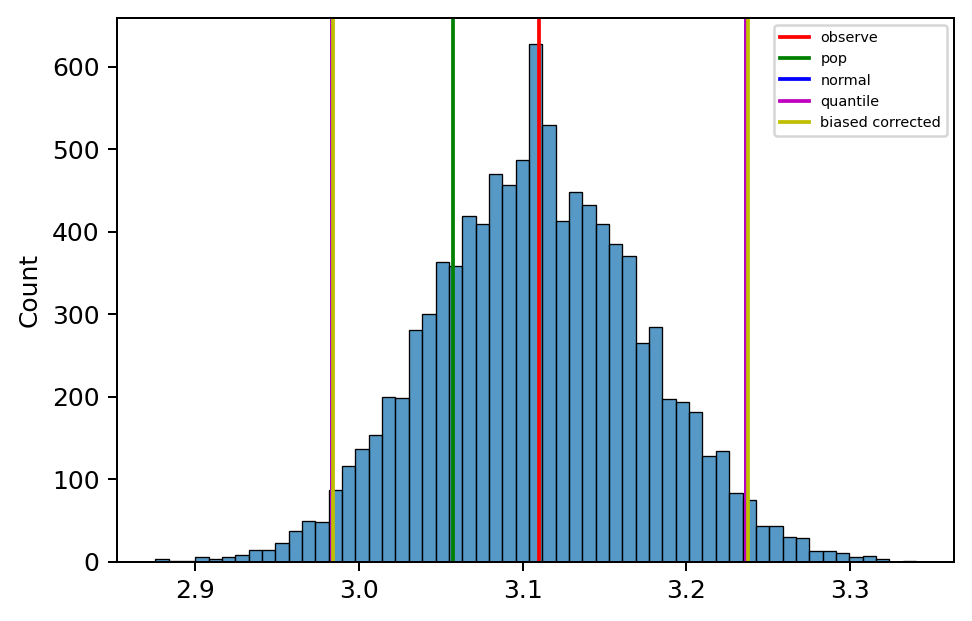

In [103]:
fig = plt.figure(dpi=180)
sns.histplot(width_mean_bt)
plt.axvline(x=mean(obs_width), color = 'r', label = 'observe')
plt.axvline(x=pop_mean, color = 'g', label = 'pop')
plt.axvline(x=normal[0], color = 'b', label = 'normal')
plt.axvline(x=normal[1], color = 'b')
plt.axvline(x=quantile[0], color = 'm', label = 'quantile')
plt.axvline(x=quantile[1], color = 'm')
plt.axvline(x=biased[0], color = 'y', label = 'biased corrected')
plt.axvline(x=biased[1], color = 'y')
plt.legend(loc='best', fontsize = 'xx-small')
plt.show()

In [126]:
# pseudo values method 
def jackknife(x, func):
    n = len(x)
    pse = []
    idx = np.arange(n)
    
    for i in range(n):
        one_out = x[idx != i]
        pse.append(n * func(x) - (n - 1) * func(one_out))
        
    return pse
        

def jackknife_block(x, func, nfold):
    kf = KFold(n_splits=nfold)
    pse = []
    
    for index,_ in kf.split(x):
        block = x[index]
        pse.append(nfold * func(x) - (nfold - 1) * func(block))
        
    return np.array(pse)


def jk_get_CI(x, confidence):
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = mean(x) + qnorm * np.std(x, ddof=1) / sqrt(len(x)) # change degree of freedom
    lower = mean(x) - qnorm * np.std(x, ddof=1) / sqrt(len(x))

    return lower, upper

In [84]:
jk = jackknife(obs_width, mean)
jk_CI = jk_get_CI(jk, 0.95)

In [118]:
jk_block = jackknife_block(obs_width, mean, nfold=5)
jk_block_CI = jk_get_CI(jk, 0.95)

In [119]:
jk_block

array([3.21, 2.86, 3.42, 3.07, 2.99])

In [120]:
jk_block_CI

(2.982394821528999, 3.237605178470999)

In [72]:
print('The population mean is', pop_mean, '\n')
print('The observed mean is', mean(obs_width), '\n')
print('Normal CI by Jackknife is', jk_CI, '\n')

The population mean is 3.0573333333333332 

The observed mean is 3.11 

Normal CI by Jackknife is (2.9823948215289984, 3.237605178470997) 



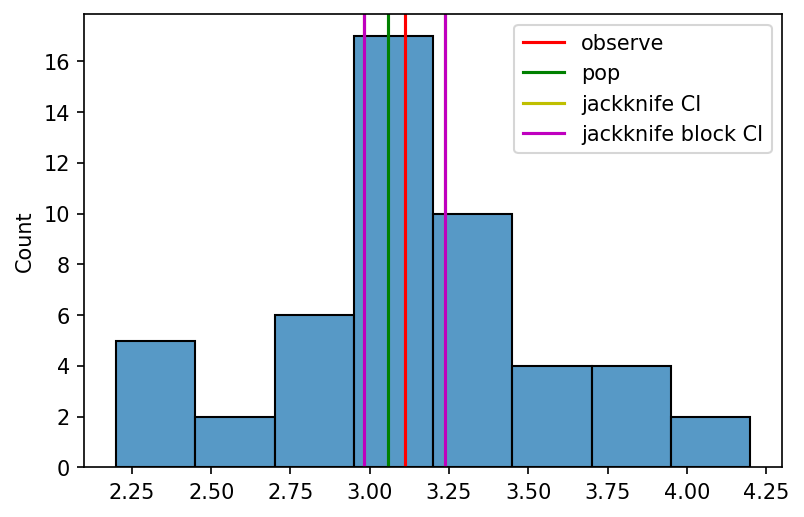

In [121]:
fig2 = plt.figure(dpi=150)
sns.histplot(jk)
plt.axvline(x=mean(obs_width), color = 'r', label = 'observe')
plt.axvline(x=pop_mean, color = 'g', label = 'pop')
plt.axvline(x=jk_CI[0], color = 'y', label = 'jackknife CI')
plt.axvline(x=jk_CI[1], color = 'y')
plt.axvline(x=jk_block_CI[0], color = 'm', label = 'jackknife block CI')
plt.axvline(x=jk_block_CI[1], color = 'm')
plt.legend(loc=0)
plt.show()

In [129]:
def bt_coverage(x, est_function, CI_function, confidence, pop_value, size, bootstrap_size):
    rate = []
    
    for i in range(size):
        resample_data = bootstrap(x, bootstrap_size, est_function)
        lower, upper = CI_function(resample_data, confidence, est_function(x))
        
        if lower < pop_value < upper:
            rate.append(1)
        else:
            rate.append(0)
    
    return rate


def jk_coverage(x, est_function, confidence, pop_value, size, nfold=None):
    rate = []
    for i in range(size):
        
        if nfold is not None: 
            resample_data = jackknife_block(x, est_function, nfold)
        else:
            resample_data = jackknife(x, est_function)
            
        lower, upper = jk_get_CI(resample_data, confidence)
        
        if lower < pop_value < upper:
            rate.append(1)
        else:
            rate.append(0)
    
    return rate

In [130]:
bt_coverage_normal = bt_coverage(obs_width, mean, get_CI_normal, 0.95, pop_mean, 20, 1000)
bt_coverage_quantile = bt_coverage(obs_width, mean, get_CI_quantile, 0.95, pop_mean, 20, 1000)
bt_coverage_biased = bt_coverage(obs_width, mean, get_CI_biased_corrected_norm, 0.95, pop_mean, 20, 1000)
jk_coverage_rate = jk_coverage(obs_width, mean, 0.95, pop_mean, 20)
jk_block_coverage = jk_coverage(obs_width, mean, 0.95, pop_mean, 20, nfold=5)

In [131]:
coverage_df = {'pop_width': [pop_mean] * 5,
               'obs_width': [mean(obs_width)] * 5,
               'resample method': ['bootstrap', 'bootstrap', 'bootstrap', 'jackknife', 'jackknife block'],
               'CI method': ['noraml', 'quantile', 'biased corrected', 'pseudo normal', 'pseudo normal'],
               'confidence': ['95%'] * 5, 
               'resample means': [bt_coverage_normal, bt_coverage_quantile, bt_coverage_biased, jk_coverage_rate, jk_block_coverage],
               'rate': [mean(bt_coverage_normal), mean(bt_coverage_quantile), 
                        mean(bt_coverage_biased), mean(jk_coverage_rate), mean(jk_block_coverage)]}

coverage_df = pd.DataFrame(coverage_df)

In [132]:
coverage_df.style

,pop_width,obs_width,resample method,CI method,confidence,resample means,rate
0,3.057333,3.110000,bootstrap,noraml,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
1,3.057333,3.110000,bootstrap,quantile,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
2,3.057333,3.110000,bootstrap,biased corrected,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
3,3.057333,3.110000,jackknife,pseudo normal,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
4,3.057333,3.110000,jackknife block,pseudo normal,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
